### Load necessary files and packages

In [1]:
from google.colab import files
uploaded = files.upload()

Saving flipkart_com-ecommerce_sample - flipkart_com-ecommerce_sample.xlsx to flipkart_com-ecommerce_sample - flipkart_com-ecommerce_sample.xlsx


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import nltk

# nltk.download('wordnet')
# nltk.download('stopwords')

Objects that will be used later in the code

In [2]:
Tokenizer = nltk.tokenize.TweetTokenizer()
Lemmatizer = nltk.stem.WordNetLemmatizer()

Imputer = KNNImputer()

ohe_name = OneHotEncoder(sparse=False)

name_le = LabelEncoder()
brand_le = LabelEncoder()
cat_le = LabelEncoder()
cat_tree_le = LabelEncoder()

### Load the Dataset

In [3]:
dataset = pd.read_excel("flipkart_com-ecommerce_sample - flipkart_com-ecommerce_sample.xlsx")
dataset = dataset.drop(columns=["uniq_id", "crawl_timestamp", "image", "product_url", "pid", "product_specifications"])
dataset = dataset[dataset["description"].notna()]
dataset.head()

,product_name,product_category_tree,retail_price,discounted_price,is_FK_Advantage_product,description,product_rating,overall_rating,brand
0,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",999.0,379.0,False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha
1,FabHomeDecor Fabric Double Sofa Bed,"[""Furniture >> Living Room Furniture >> Sofa B...",32157.0,22646.0,False,FabHomeDecor Fabric Double Sofa Bed (Finish Co...,No rating available,No rating available,FabHomeDecor
2,AW Bellies,"[""Footwear >> Women's Footwear >> Ballerinas >...",999.0,499.0,False,Key Features of AW Bellies Sandals Wedges Heel...,No rating available,No rating available,AW
3,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",699.0,267.0,False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha
4,Sicons All Purpose Arnica Dog Shampoo,"[""Pet Supplies >> Grooming >> Skin & Coat Care...",220.0,210.0,False,Specifications of Sicons All Purpose Arnica Do...,No rating available,No rating available,Sicons


### Data Analysis & Cleaning

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19998 entries, 0 to 19999
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   product_name             19998 non-null  object 
 1   product_category_tree    19998 non-null  object 
 2   retail_price             19920 non-null  float64
 3   discounted_price         19920 non-null  float64
 4   is_FK_Advantage_product  19998 non-null  bool   
 5   description              19998 non-null  object 
 6   product_rating           19998 non-null  object 
 7   overall_rating           19998 non-null  object 
 8   brand                    14135 non-null  object 
dtypes: bool(1), float64(2), object(6)
memory usage: 1.4+ MB


In [5]:
dataset["product_name"] = name_le.fit_transform(dataset["product_name"])

dataset["product_category"] = dataset["product_category_tree"].str.split(" >>", 1).str[0]
dataset["product_category"] = cat_tree_le.fit_transform(dataset["product_category"])

dataset["product_category_tree"] = cat_le.fit_transform(dataset["product_category_tree"])

dataset["is_FK_Advantage_product"] = pd.to_numeric(dataset["is_FK_Advantage_product"], errors='coerce')

dataset["product_rating"] = pd.to_numeric(dataset["product_rating"], errors='coerce')

dataset["overall_rating"] = pd.to_numeric(dataset["overall_rating"], errors='coerce')

dataset["brand"] = dataset["brand"].astype("str")
dataset["brand"] = brand_le.fit_transform(dataset["brand"])

dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19998 entries, 0 to 19999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   product_name             19998 non-null  int64  
 1   product_category_tree    19998 non-null  int64  
 2   retail_price             19920 non-null  float64
 3   discounted_price         19920 non-null  float64
 4   is_FK_Advantage_product  19998 non-null  bool   
 5   description              19998 non-null  object 
 6   product_rating           1849 non-null   float64
 7   overall_rating           1849 non-null   float64
 8   brand                    19998 non-null  int64  
 9   product_category         19998 non-null  int64  
dtypes: bool(1), float64(4), int64(4), object(1)
memory usage: 1.5+ MB


In [6]:
dataset = dataset.drop(columns=["product_rating", "overall_rating"])
dataset[["retail_price"]] = Imputer.fit_transform(dataset[["retail_price"]])
dataset[["discounted_price"]] = Imputer.fit_transform(dataset[["discounted_price"]])
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19998 entries, 0 to 19999
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   product_name             19998 non-null  int64  
 1   product_category_tree    19998 non-null  int64  
 2   retail_price             19998 non-null  float64
 3   discounted_price         19998 non-null  float64
 4   is_FK_Advantage_product  19998 non-null  bool   
 5   description              19998 non-null  object 
 6   brand                    19998 non-null  int64  
 7   product_category         19998 non-null  int64  
dtypes: bool(1), float64(2), int64(4), object(1)
memory usage: 1.2+ MB


##### Visualize the data

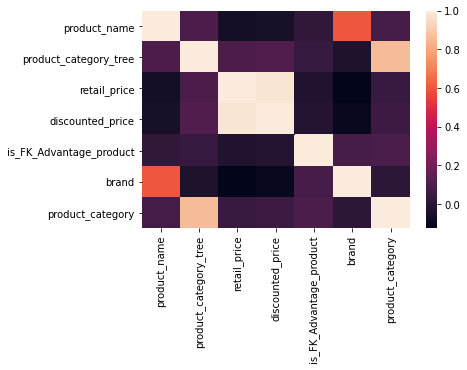

In [7]:
sns.heatmap(dataset.corr())

If some columns have very high correlation, then only one of them is required. For example: in this case retail price and discounted price are highly correlated. Similary, product name and brand are also highly correlated. Hence only of the highly correlated columns is kept for the input dataset

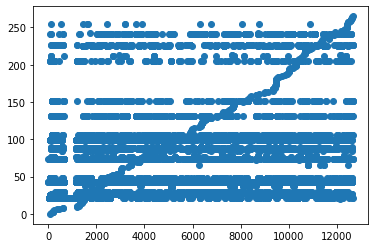

In [8]:
plt.scatter(dataset["product_name"], dataset["product_category"])

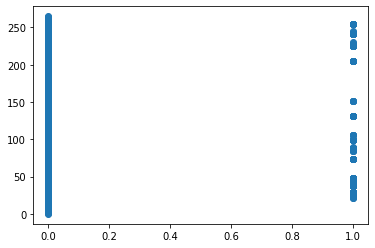

In [9]:
plt.scatter(dataset["is_FK_Advantage_product"], dataset["product_category"])

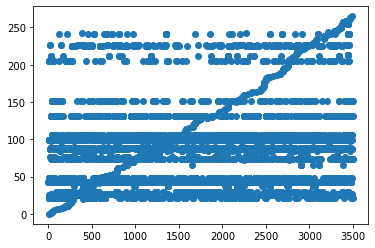

In [10]:
plt.scatter(dataset["brand"], dataset["product_category"])

### Choose the columns (other than product descrption) as input columns and pre-process them

In [11]:
prod_name = ohe_name.fit_transform(dataset[["product_name"]])
retail_price = np.asarray(dataset[["retail_price"]])
advantage_product = np.asarray(dataset[["is_FK_Advantage_product"]])

In [12]:
prod_name.shape, retail_price.shape, advantage_product.shape

((19998, 12675), (19998, 1), (19998, 1))

#### Create input samples for product description
The maximum input length is chosen by calculating the mean length of the product description.<br />
The product description is pre-processed. Pre-processing includes: Tokenization, Stop Word Removal and Lemmatization <br />
The description having length < max_input_len are padded with 0's and for description having length > max_input_len, only the latest max_input_len words are taken.

In [13]:
bow = set()
word_to_id = {"PADDING": 0}
id_to_word = {0: "PADDING"}
id = 1

lengths = []
input_len = int(dataset["description"].str.len().mean())
description_trans = []
for i, row in dataset.iterrows():
  description = row["description"]
  word = Tokenizer.tokenize(description)
  stop_words = nltk.corpus.stopwords.words("english")
  filtered_sent = []
  lengths.append(len(word))
  for w in word:
    if w not in stop_words:
      w = Lemmatizer.lemmatize(w)
      bow.add(w)
      if word_to_id.get(w) is None:
        word_to_id[w] = id
        id_to_word[id] = w
        id += 1
      filtered_sent.append(word_to_id[w])
  filtered_sent = filtered_sent[:input_len]
  filtered_sent = np.pad(filtered_sent, (0,input_len-len(filtered_sent)), "constant", constant_values=0)
  description_trans.append(filtered_sent)
description_trans = np.asarray(description_trans)

### Create Input Dataset

In [14]:
X_description = description_trans
X_meta = np.hstack([prod_name, retail_price, advantage_product])
Y = np.asarray(dataset[["product_category"]])

In [15]:
X_description.shape, X_meta.shape, Y.shape

((19998, 430), (19998, 12677), (19998, 1))

### Train-Test Split

In [16]:
d_train, d_test, m_train, m_test, y_train, y_test = train_test_split(X_description, X_meta, Y, test_size=0.50, random_state=42)

# Experiments with different models

### Method for creating model

In [17]:
def Model(x_description, x_meta, embed_size=16, LSTM=128, dropout=0.25):
  input_description = tf.keras.layers.Input(shape=x_description)
  x = tf.keras.layers.Embedding(id, embed_size, mask_zero=True, input_length=input_len)(input_description)
  x = tf.keras.layers.Dropout(dropout)(x)

  x = tf.keras.layers.LSTM(LSTM, return_sequences=True)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(dropout)(x)

  x = tf.keras.layers.LSTM(LSTM*2)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(dropout)(x)

  input_meta = tf.keras.layers.Input(shape=x_meta)
  x = tf.keras.layers.Concatenate()([x, input_meta])
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Dense(4086)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation(tf.nn.leaky_relu)(x)
  x = tf.keras.layers.Dropout(dropout)(x)

  x = tf.keras.layers.Dense(1024)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation(tf.nn.leaky_relu)(x)
  x = tf.keras.layers.Dropout(dropout)(x)
  
  x = tf.keras.layers.Dense(len(dataset["product_category"].unique()))(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation(tf.nn.softmax)(x)
  return tf.keras.Model([input_description, input_meta], x)

### Model-1

In [19]:
category_prediction_model_32_128 = Model(X_description[0].shape, X_meta[0].shape)
category_prediction_model_32_128.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics="accuracy")
category_prediction_model_32_128.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 430)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 430, 16)      578912      input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 430, 16)      0           embedding[0][0]                  
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 430, 128)     74240       dropout[0][0]                    
______________________________________________________________________________________________

In [20]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='weights_32_128/', save_weights_only=True, save_best_only=True, monitor="val_accuracy", mode="max")
H = category_prediction_model_32_128.fit([d_train, m_train], y_train, validation_split=0.25, epochs=50, batch_size=256, shuffle=True, callbacks=[checkpoint_callback])

Epoch 1/50
30/30 [==============================] - 46s 230ms/step - loss: 4.6694 - accuracy: 0.2081 - val_loss: 5.3624 - val_accuracy: 0.0516
Epoch 2/50
30/30 [==============================] - 4s 142ms/step - loss: 3.1173 - accuracy: 0.7898 - val_loss: 5.3064 - val_accuracy: 0.0228
Epoch 3/50
30/30 [==============================] - 4s 139ms/step - loss: 2.4257 - accuracy: 0.9323 - val_loss: 5.1762 - val_accuracy: 0.0296
Epoch 4/50
30/30 [==============================] - 4s 141ms/step - loss: 2.1607 - accuracy: 0.9629 - val_loss: 5.0246 - val_accuracy: 0.0672
Epoch 5/50
30/30 [==============================] - 4s 141ms/step - loss: 1.9325 - accuracy: 0.9859 - val_loss: 4.8728 - val_accuracy: 0.0904
Epoch 6/50
30/30 [==============================] - 4s 142ms/step - loss: 1.8200 - accuracy: 0.9888 - val_loss: 4.7489 - val_accuracy: 0.1448
Epoch 7/50
30/30 [==============================] - 4s 143ms/step - loss: 1.6674 - accuracy: 0.9951 - val_loss: 4.5762 - val_accuracy: 0.2720
Epoch

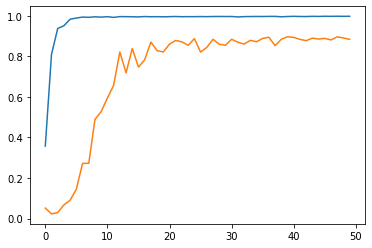

In [21]:
plt.plot(H.history["accuracy"])
plt.plot(H.history["val_accuracy"])

### Model-2

In [22]:
category_prediction_model_32_256 = Model(X_description[0].shape, X_meta[0].shape, LSTM=256)
category_prediction_model_32_256.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics="accuracy")

In [23]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='weights_32_256/', save_weights_only=True, save_best_only=True, monitor="val_accuracy", mode="max")
H = category_prediction_model_32_256.fit([d_train, m_train], y_train, validation_split=0.25, epochs=50, batch_size=256, shuffle=True, callbacks=[checkpoint_callback])

Epoch 1/50
30/30 [==============================] - 17s 295ms/step - loss: 4.7703 - accuracy: 0.2451 - val_loss: 5.3498 - val_accuracy: 0.0868
Epoch 2/50
30/30 [==============================] - 7s 218ms/step - loss: 3.4064 - accuracy: 0.7113 - val_loss: 5.1704 - val_accuracy: 0.0824
Epoch 3/50
30/30 [==============================] - 7s 221ms/step - loss: 2.7819 - accuracy: 0.8549 - val_loss: 5.1579 - val_accuracy: 0.0464
Epoch 4/50
30/30 [==============================] - 7s 219ms/step - loss: 2.3581 - accuracy: 0.9249 - val_loss: 5.0155 - val_accuracy: 0.0856
Epoch 5/50
30/30 [==============================] - 7s 221ms/step - loss: 2.1116 - accuracy: 0.9560 - val_loss: 4.7995 - val_accuracy: 0.0568
Epoch 6/50
30/30 [==============================] - 7s 222ms/step - loss: 1.8791 - accuracy: 0.9774 - val_loss: 4.9682 - val_accuracy: 0.0720
Epoch 7/50
30/30 [==============================] - 7s 219ms/step - loss: 1.7631 - accuracy: 0.9841 - val_loss: 5.0509 - val_accuracy: 0.1092
Epoch

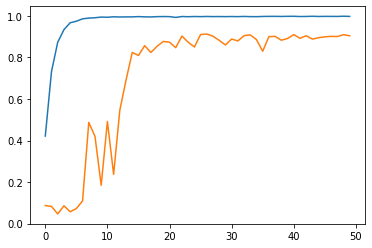

In [24]:
plt.plot(H.history["accuracy"])
plt.plot(H.history["val_accuracy"])

### Model-3

In [25]:
category_prediction_model_32_512 = Model(X_description[0].shape, X_meta[0].shape, LSTM=512)
category_prediction_model_32_512.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics="accuracy")

In [26]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='weights_32_512/', save_weights_only=True, save_best_only=True, monitor="val_accuracy", mode="max")
H = category_prediction_model_32_512.fit([d_train, m_train], y_train, validation_split=0.25, epochs=50, batch_size=256, shuffle=True, callbacks=[checkpoint_callback])

Epoch 1/50
30/30 [==============================] - 24s 549ms/step - loss: 4.8924 - accuracy: 0.2216 - val_loss: 5.0413 - val_accuracy: 0.3984
Epoch 2/50
30/30 [==============================] - 15s 486ms/step - loss: 3.6914 - accuracy: 0.6423 - val_loss: 5.1476 - val_accuracy: 0.2932
Epoch 3/50
30/30 [==============================] - 15s 485ms/step - loss: 3.0809 - accuracy: 0.7866 - val_loss: 5.2919 - val_accuracy: 0.0704
Epoch 4/50
30/30 [==============================] - 14s 480ms/step - loss: 2.5770 - accuracy: 0.8918 - val_loss: 5.3597 - val_accuracy: 0.0360
Epoch 5/50
30/30 [==============================] - 14s 477ms/step - loss: 2.2703 - accuracy: 0.9223 - val_loss: 6.6701 - val_accuracy: 0.0056
Epoch 6/50
30/30 [==============================] - 14s 474ms/step - loss: 2.0456 - accuracy: 0.9461 - val_loss: 6.6425 - val_accuracy: 0.0080
Epoch 7/50
30/30 [==============================] - 14s 476ms/step - loss: 1.7435 - accuracy: 0.9810 - val_loss: 6.2321 - val_accuracy: 0.0048

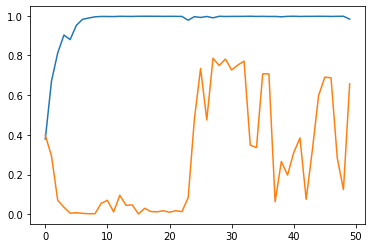

In [27]:
plt.plot(H.history["accuracy"])
plt.plot(H.history["val_accuracy"])

### Model-4

In [28]:
category_prediction_model_64_128 = Model(X_description[0].shape, X_meta[0].shape, embed_size=64)
category_prediction_model_64_128.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics="accuracy")

In [29]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='weights_64_128/', save_weights_only=True, save_best_only=True, monitor="val_accuracy", mode="max")
H = category_prediction_model_64_128.fit([d_train, m_train], y_train, validation_split=0.25, epochs=50, batch_size=256, shuffle=True, callbacks=[checkpoint_callback])

Epoch 1/50
30/30 [==============================] - 15s 234ms/step - loss: 4.5245 - accuracy: 0.2641 - val_loss: 5.4021 - val_accuracy: 0.0900
Epoch 2/50
30/30 [==============================] - 5s 158ms/step - loss: 2.7389 - accuracy: 0.8740 - val_loss: 5.3930 - val_accuracy: 0.0208
Epoch 3/50
30/30 [==============================] - 5s 157ms/step - loss: 2.3636 - accuracy: 0.9289 - val_loss: 5.3746 - val_accuracy: 0.0124
Epoch 4/50
30/30 [==============================] - 5s 161ms/step - loss: 2.0858 - accuracy: 0.9722 - val_loss: 5.2671 - val_accuracy: 0.0112
Epoch 5/50
30/30 [==============================] - 5s 160ms/step - loss: 1.9141 - accuracy: 0.9797 - val_loss: 5.1183 - val_accuracy: 0.0432
Epoch 6/50
30/30 [==============================] - 5s 158ms/step - loss: 1.8175 - accuracy: 0.9854 - val_loss: 4.5548 - val_accuracy: 0.3344
Epoch 7/50
30/30 [==============================] - 5s 160ms/step - loss: 1.6626 - accuracy: 0.9920 - val_loss: 4.4880 - val_accuracy: 0.3172
Epoch

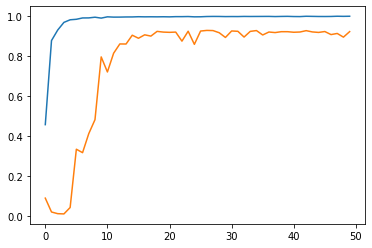

In [30]:
plt.plot(H.history["accuracy"])
plt.plot(H.history["val_accuracy"])

### Model-5

In [31]:
category_prediction_model_64_256 = Model(X_description[0].shape, X_meta[0].shape, embed_size=64, LSTM=256)
category_prediction_model_64_256.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics="accuracy")

In [32]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='weights_64_256/', save_weights_only=True, save_best_only=True, monitor="val_accuracy", mode="max")
H = category_prediction_model_64_256.fit([d_train, m_train], y_train, validation_split=0.25, epochs=50, batch_size=256, shuffle=True, callbacks=[checkpoint_callback])

Epoch 1/50
30/30 [==============================] - 17s 317ms/step - loss: 4.5872 - accuracy: 0.3020 - val_loss: 5.4832 - val_accuracy: 0.0724
Epoch 2/50
30/30 [==============================] - 7s 241ms/step - loss: 3.0306 - accuracy: 0.7978 - val_loss: 5.3174 - val_accuracy: 0.0740
Epoch 3/50
30/30 [==============================] - 7s 239ms/step - loss: 2.5378 - accuracy: 0.8947 - val_loss: 5.4005 - val_accuracy: 0.0960
Epoch 4/50
30/30 [==============================] - 7s 240ms/step - loss: 2.2339 - accuracy: 0.9382 - val_loss: 5.3399 - val_accuracy: 0.0348
Epoch 5/50
30/30 [==============================] - 7s 239ms/step - loss: 1.9705 - accuracy: 0.9666 - val_loss: 5.4472 - val_accuracy: 0.0412
Epoch 6/50
30/30 [==============================] - 7s 238ms/step - loss: 1.8381 - accuracy: 0.9731 - val_loss: 5.2333 - val_accuracy: 0.0828
Epoch 7/50
30/30 [==============================] - 7s 239ms/step - loss: 1.7342 - accuracy: 0.9691 - val_loss: 4.2916 - val_accuracy: 0.2908
Epoch

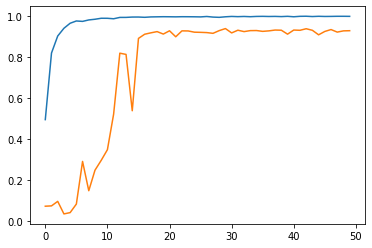

In [33]:
plt.plot(H.history["accuracy"])
plt.plot(H.history["val_accuracy"])

### Model-6

In [34]:
category_prediction_model_64_512 = Model(X_description[0].shape, X_meta[0].shape, embed_size=64, LSTM=512)
category_prediction_model_64_512.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics="accuracy")

In [35]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='weights_64_512/', save_weights_only=True, save_best_only=True, monitor="val_accuracy", mode="max")
H = category_prediction_model_64_512.fit([d_train, m_train], y_train, validation_split=0.25, epochs=50, batch_size=256, shuffle=True, callbacks=[checkpoint_callback])

Epoch 1/50
30/30 [==============================] - 25s 569ms/step - loss: 4.8391 - accuracy: 0.1804 - val_loss: 5.4404 - val_accuracy: 0.0748
Epoch 2/50
30/30 [==============================] - 15s 504ms/step - loss: 3.4167 - accuracy: 0.7196 - val_loss: 4.9659 - val_accuracy: 0.0268
Epoch 3/50
30/30 [==============================] - 15s 506ms/step - loss: 2.6877 - accuracy: 0.8668 - val_loss: 4.8380 - val_accuracy: 0.0632
Epoch 4/50
30/30 [==============================] - 15s 495ms/step - loss: 2.3370 - accuracy: 0.9173 - val_loss: 5.2984 - val_accuracy: 0.0440
Epoch 5/50
30/30 [==============================] - 15s 493ms/step - loss: 2.0733 - accuracy: 0.9493 - val_loss: 4.9332 - val_accuracy: 0.0512
Epoch 6/50
30/30 [==============================] - 15s 494ms/step - loss: 1.8969 - accuracy: 0.9571 - val_loss: 5.9041 - val_accuracy: 0.0232
Epoch 7/50
30/30 [==============================] - 15s 498ms/step - loss: 1.7688 - accuracy: 0.9656 - val_loss: 5.4345 - val_accuracy: 0.0664

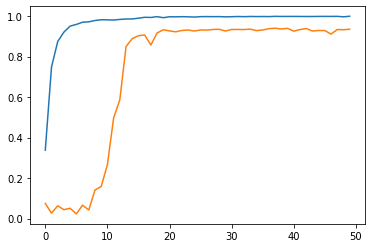

In [36]:
plt.plot(H.history["accuracy"])
plt.plot(H.history["val_accuracy"])

### Load all the models with best weights and evaluate


In [25]:
category_prediction_model_32_128 = Model(X_description[0].shape, X_meta[0].shape, LSTM=128)
category_prediction_model_32_128.load_weights('weights_32_128/')
category_prediction_model_32_128.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
print("Embed Size: 32, LSTM: 128")
print("\tTrain Accuracy:", category_prediction_model_32_128.evaluate([d_train, m_train], y_train, verbose=0)[1], "Test Accuracy:", category_prediction_model_32_128.evaluate([d_test, m_test], y_test, verbose=0)[1])
del category_prediction_model_32_128

category_prediction_model_32_256 = Model(X_description[0].shape, X_meta[0].shape, LSTM=256)
category_prediction_model_32_256.load_weights('weights_32_256/')
category_prediction_model_32_256.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
print("Embed Size: 32, LSTM: 256")
print("\tTrain Accuracy:", category_prediction_model_32_256.evaluate([d_train, m_train], y_train, verbose=0)[1], "Test Accuracy:", category_prediction_model_32_256.evaluate([d_test, m_test], y_test, verbose=0)[1])
del category_prediction_model_32_256

category_prediction_model_32_512 = Model(X_description[0].shape, X_meta[0].shape, LSTM=512)
category_prediction_model_32_512.load_weights('weights_32_512/')
category_prediction_model_32_512.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
print("Embed Size: 32, LSTM: 512")
print("\tTrain Accuracy:", category_prediction_model_32_512.evaluate([d_train, m_train], y_train, verbose=0)[1], "Test Accuracy:", category_prediction_model_32_512.evaluate([d_test, m_test], y_test, verbose=0)[1])
del category_prediction_model_32_512

category_prediction_model_64_128 = Model(X_description[0].shape, X_meta[0].shape, embed_size=64, LSTM=128)
category_prediction_model_64_128.load_weights('weights_64_128/')
category_prediction_model_64_128.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
print("Embed Size: 64, LSTM: 128")
print("\tTrain Accuracy:", category_prediction_model_64_128.evaluate([d_train, m_train], y_train, verbose=0)[1], "Test Accuracy:", category_prediction_model_64_128.evaluate([d_test, m_test], y_test, verbose=0)[1])
del category_prediction_model_64_128

category_prediction_model_64_256 = Model(X_description[0].shape, X_meta[0].shape, embed_size=64, LSTM=256)
category_prediction_model_64_256.load_weights('weights_64_256/')
category_prediction_model_64_256.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
print("Embed Size: 64, LSTM: 256")
print("\tTrain Accuracy:", category_prediction_model_64_256.evaluate([d_train, m_train], y_train, verbose=0)[1], "Test Accuracy:", category_prediction_model_64_256.evaluate([d_test, m_test], y_test, verbose=0)[1])
del category_prediction_model_64_256

category_prediction_model_64_512 = Model(X_description[0].shape, X_meta[0].shape, embed_size=64, LSTM=512)
category_prediction_model_64_512.load_weights('weights_64_512/')
category_prediction_model_64_512.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"])
print("Embed Size: 64, LSTM: 512")
print("\tTrain Accuracy:", category_prediction_model_64_512.evaluate([d_train, m_train], y_train, verbose=0)[1], "Test Accuracy:", category_prediction_model_64_512.evaluate([d_test, m_test], y_test, verbose=0)[1])
del category_prediction_model_64_512

Embed Size: 32, LSTM: 128
	Train Accuracy: 0.9726972579956055 Test Accuracy: 0.8950895071029663
Embed Size: 32, LSTM: 256
	Train Accuracy: 0.9765976667404175 Test Accuracy: 0.9155915379524231
Embed Size: 32, LSTM: 512
	Train Accuracy: 0.943994402885437 Test Accuracy: 0.7828782796859741
Embed Size: 64, LSTM: 128
	Train Accuracy: 0.9804980754852295 Test Accuracy: 0.9315931797027588
Embed Size: 64, LSTM: 256
	Train Accuracy: 0.9830983281135559 Test Accuracy: 0.9399939775466919
Embed Size: 64, LSTM: 512
	Train Accuracy: 0.9840984344482422 Test Accuracy: 0.9441944360733032
